In [1]:
!pip install torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00


In [2]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [3]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import random
import time
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 0.005
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2
VOCAB_SIZE=20000

torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [5]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [6]:
from transformers import BertTokenizerFast, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

class IMDBBertDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_len=256):
        self.data = pd.read_csv(csv_path)
        self.data['sentiment'] = self.data['sentiment'].map({'positive': 1, 'negative': 0})
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['review']
        label = int(self.data.iloc[idx]['sentiment'])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        # squeeze to remove batch dim
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
full_dataset = IMDBBertDataset(
    '/content/drive/My Drive/IMDB_sentiment_analysis/IMDB Dataset.csv',
    tokenizer=tokenizer,
    max_len=256
)

train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_size = int(0.85 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(len(train_dataset), len(val_dataset), len(test_dataset))


34000 6000 10000


In [10]:
from transformers import BertTokenizerFast, BertForSequenceClassification

model_name = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_name)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=OUTPUT_DIM
).to(DEVICE)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="./bert-finetuned",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()


/tmp/ipython-input-4042795250.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.486700
200,0.314000
300,0.298800
400,0.315400
500,0.257500
600,0.249100
700,0.274700
800,0.270400
900,0.252800
1000,0.230300


TrainOutput(global_step=6375, training_loss=0.1630526445426193, metrics={'train_runtime': 4801.8724, 'train_samples_per_second': 21.242, 'train_steps_per_second': 1.328, 'total_flos': 1.341866382336e+16, 'train_loss': 0.1630526445426193, 'epoch': 3.0})

In [12]:
import numpy as np

pred_output = trainer.predict(val_dataset)

logits = pred_output.predictions   # shape: [N, 2]
labels = pred_output.label_ids     # shape: [N]

In [13]:
preds = np.argmax(logits, axis=1)

In [14]:
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
pos_probs = probs[:, 1]

In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

accuracy  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall    = recall_score(labels, preds)
f1        = f1_score(labels, preds)
roc_auc   = roc_auc_score(labels, pos_probs)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")


Accuracy : 0.9210
Precision: 0.9199
Recall   : 0.9199
F1-score : 0.9199
ROC-AUC  : 0.9762


ROC-AUC: 0.9762170023089868


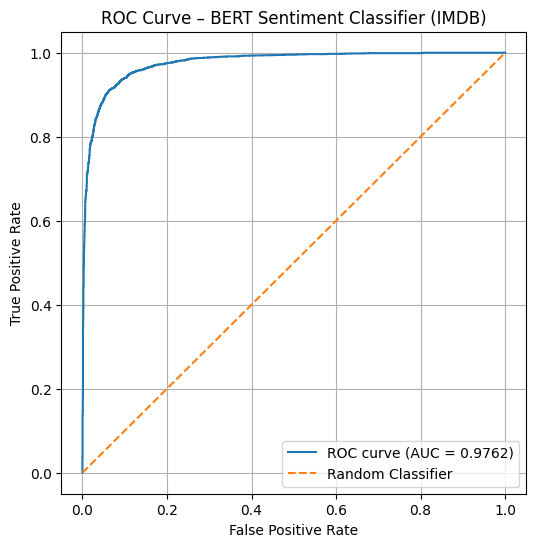

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(labels, pos_probs)
roc_auc = roc_auc_score(labels, pos_probs)

print("ROC-AUC:", roc_auc)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – BERT Sentiment Classifier (IMDB)")
plt.legend(loc="lower right")
plt.grid(True)

plt.show()
